In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib qt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def smoothed_sample_anomalies(scores, halflife=2):
    '''
        Exponential weighted sample likelihood.
        Args:
            scores - result of running ClusterAD-DataSample algorithm for samples
            halflife -  size of smoothing window.
    '''
    frames = [pd.DataFrame(series) for series in scores]
    return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])

In [4]:
def extract_anomaly_target(frame, frame_period, halflife,
                            horizont, top=0.01, more_info=False, **kwargs):
    '''
        Extract target anomalies from 2-dim frame.
        Args:
            frame - 2-dim pandas Dataframe
            frame_period - period for division into group of independent series
            halflife - size of smoothing window
            top - anomaly bound
            more_info - return more important objects if True
    '''
    import sys
    from copy import deepcopy
    import gaussian_mixture_anomaly_detection
    assert len(frame.shape) == 2
    assert isinstance(frame, pd.DataFrame)
    frame = np.array(deepcopy(frame))
    start_size = frame.shape[0]
    if frame.shape[0] % frame_period != 0:
        print("remove last elements until period", file=sys.stderr)
        for _ in np.arange(frame.shape[0] % frame_period):
            frame = np.delete(frame, -1, 0)

    data = frame.reshape(-1, frame_period, frame.shape[1])
    detector = gaussian_mixture_anomaly_detection.GaussianMixtureInTimeAnomalyDetector(**kwargs)
    scores = detector.fit(data)
    smoothed_scores = smoothed_sample_anomalies(scores, halflife)
    anomalies, treshold = detector.find_anomalies(smoothed_scores, anomaly_top=top)
    anomaly_indexes = [t[1][0] * frame_period + t[1][1] for t in anomalies]
    if horizont > 0:
        all_anomalies = set()
        for a in anomaly_indexes:
            for l in np.arange(horizont):
                all_anomalies.add(max(a - l, 0))
    else:
        all_anomalies = anomaly_indexes

    targets = np.zeros(start_size)

    for a in all_anomalies:
        targets[a] = 1

    if more_info:
        return targets, scores, smoothed_scores, treshold
    else:
        return targets

In [5]:
def plot_events(events, features, names):
    if len(events) > 1:
        events = events[0]
    if len(features.shape) == 1:
        features = [features]
    assert(len(names) == len(features))
    for name, f in zip(names, features):
        plt.figure(figsize=(10,8))
        plt.title(name)
        plt.plot(f, color='blue')
        plt.plot(np.where(events)[0],f[np.where(events)[0]],'*', color='red')
        plt.grid(True)
        plt.show()

In [27]:
def merge_frames(big_f, small_f):
    good_small_inds = np.array(small_f.index)
    big_idx = np.array(big_f.index)
    cur = 0
    for i, ind in enumerate(good_small_inds):
        while cur < len(big_idx) and big_idx[cur] < ind:
            cur += 1
        if cur == len(big_idx):
            break
        good_small_inds[i] = big_idx[cur]
        limit = i + 1
    plt.plot(good_small_inds)
    plt.plot(big_idx)
    small_f = small_f.iloc[:limit]    
    small_f.index = good_small_inds[:limit]
    return big_f.join(small_f, how='inner')

In [7]:
names = ['Stove1', 'Bench1', 'Ceiling1', 'Doorway1', 'Floor1', 'Outdoor1']

In [8]:
pools = [pd.read_csv('data/{}.csv'.format(name), index_col='timestamps') for name in names]

In [9]:
pools = [p.sort_index() for p in pools]

In [10]:
[p.shape for p in pools]

[(133645, 2), (133622, 2), (54186, 16), (54011, 16), (54170, 16), (54243, 16)]

In [11]:
pools[0].index

Int64Index([1542924742034, 1542924743033, 1542924744047, 1542924745233,
            1542924746088, 1542924747108, 1542924748148, 1542924749168,
            1542924750187, 1542924750930,
            ...
            1543068713411, 1543068714400, 1543068715401, 1543068716401,
            1543068717497, 1543068718701, 1543068719500, 1543068720409,
            1543068721402, 1543068722403],
           dtype='int64', name='timestamps', length=133645)

In [12]:
pools[1].index

Int64Index([1542924742055, 1542924743055, 1542924744068, 1542924745255,
            1542924746109, 1542924747129, 1542924748444, 1542924749189,
            1542924750209, 1542924750951,
            ...
            1543067406215, 1543067407215, 1543067408216, 1543067409416,
            1543067410216, 1543067411223, 1543067412214, 1543067413214,
            1543067414327, 1543067415527],
           dtype='int64', name='timestamps', length=133622)

In [28]:
for i, z in enumerate(zip(names, pools)):
    name, p = z
    l = np.where(p.index > 1.54297 * 1e12)
    pools[i] = p.iloc[l]
    fix = lambda c: c + '_{}'.format(name)
    pools[i].columns = [fix(c) for c in p.columns]

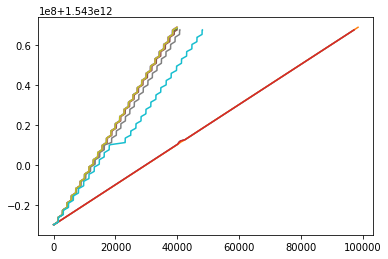

In [30]:
bfp = pools[0]
for name, p in zip(names[1:], pools[1:]):
    bfp = merge_frames(bfp, p)

In [31]:
bfp.head()

,Water vapor saturation pressure_Stove1,Temperature_Stove1,Carbon Dioxide concentration_Bench1,Temperature_Bench1,Water vapor saturation pressure_Ceiling1,Absolute humidity at NTP_Ceiling1,Wet-bulb temperature_Ceiling1,Dew point temperature_Ceiling1,Relative humidity_Ceiling1,Enthalpy_Ceiling1,...,Mixing ratio_Outdoor1,Dew point temperature difference_Outdoor1,Water concentration_Outdoor1,Temperature_Outdoor1,Dew point temperature at 1 atm_Outdoor1,Dew/frost point temperature_Outdoor1,Water vapor pressure_Outdoor1,Dew/frost point temperature at 1 atm_Outdoor1,Absolute humidity_Outdoor1,Water mass fraction_Outdoor1
1542970115132,3652.88,140.4,380.0,31.28,81.13,0.07,20.05,5.27,10.93,56.33,...,3.99,3.06,6415,3.77,0.71,0.71,6.44,0.71,5.05,3990
1542970115132,3652.88,140.4,380.0,31.28,81.13,0.07,20.05,5.27,10.93,56.33,...,3.98,3.07,6403,3.76,0.69,0.69,6.43,0.69,5.04,3982
1542970115132,3652.88,140.4,380.0,31.28,81.13,0.07,20.05,5.27,10.93,56.33,...,3.98,3.08,6397,3.75,0.67,0.67,6.42,0.67,5.04,3979
1542970115132,3652.88,140.4,380.0,31.28,81.13,0.07,20.05,5.27,10.93,56.33,...,3.97,3.09,6390,3.75,0.66,0.66,6.41,0.66,5.03,3974
1542970115132,3652.88,140.4,380.0,31.28,81.13,0.07,20.05,5.27,10.93,56.33,...,3.97,3.09,6388,3.74,0.65,0.65,6.41,0.65,5.03,3973


In [32]:
bfp.to_csv('data/bfp6.csv')

In [33]:
deltas = bfp.diff()

In [34]:
bfp.index

Int64Index([1542970115132, 1542970115132, 1542970115132, 1542970115132,
            1542970115132, 1542970115132, 1542970115132, 1542970115132,
            1542970115132, 1542970115132,
            ...
            1543067408195, 1543067409395, 1543067409395, 1543067411202,
            1543067412193, 1543067413193, 1543067414305, 1543067414305,
            1543067415505, 1543067416305],
           dtype='int64', length=68643)

In [35]:
deltas = np.divide(bfp.diff()[1:], np.array(bfp.index[1:] - bfp.index[:-1] + 1).reshape(-1,1))

In [57]:
g = extract_anomaly_target(pd.DataFrame(deltas.values[:, good_features]), 
    frame_period=100, halflife=0, horizont=100, top=1e-3, more_info=True, n_min=10, n_max=100, step=10)

remove last elements until period
100%|██████████| 10/10 [01:48<00:00, 10.82s/it]
Best number of clusters (according to BIC) - 90.
Sample clusters fitting - OK.
100%|██████████| 686/686 [02:02<00:00,  5.60it/s]
Probabilities memorization - OK.
Log-likelihood evaluation - OK.


In [37]:
# list(enumerate(bfp.columns))

In [58]:
good_features = [3, 2, 13]

In [61]:
plot_events(g, bfp.values.T[good_features], bfp.columns[good_features])

In [67]:
g[0].shape, g[2].reshape(-1).shape

((68642,), (68600,))

In [70]:
events = pd.DataFrame(data=np.concatenate([g[0][:-42].reshape(-1,1), -g[2].reshape(-1,1)],axis=1),
             index=bfp.index[:-43], columns=['is_anomaly', 'neg_log_anomaly_score'])

In [71]:
bfp_mini = pd.DataFrame(bfp.values[:,good_features], columns = bfp.columns[good_features], index=bfp.index)

In [72]:
bfp_mini.shape

(68643, 3)

In [73]:
events.shape

(68600, 2)

In [76]:
pd.concat([bfp_mini[:-43], events],axis=1).to_csv('data/bfp6_with_anomaly_score.csv', index_label='Timestamps')